# Домашнее задание: Детектирование аномалий

### Постановка задачи

Оценить, есть ли влияние от рекламы чая «Ахмад» в передаче «Что? Где? Когда?» на его продажи.


In [168]:
import pandas as pd
import numpy as np

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import kendalltau

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.offline as py

In [100]:
df = pd.read_csv('tea_demand.zip', sep='\t')
display(df)
df.groupby('brand_id').sum()['receipts_count']

,brand_id,date,receipts_count
0,5152,2016-07-01,98
1,178,2016-07-01,234
2,29,2016-07-01,622
3,5152,2016-07-02,87
4,178,2016-07-02,185
...,...,...,...
454,178,2016-11-29,222
455,29,2016-11-29,1173
456,5152,2016-11-30,311
457,178,2016-11-30,227


brand_id
29      90535
178     50038
5152    25681
Name: receipts_count, dtype: int64

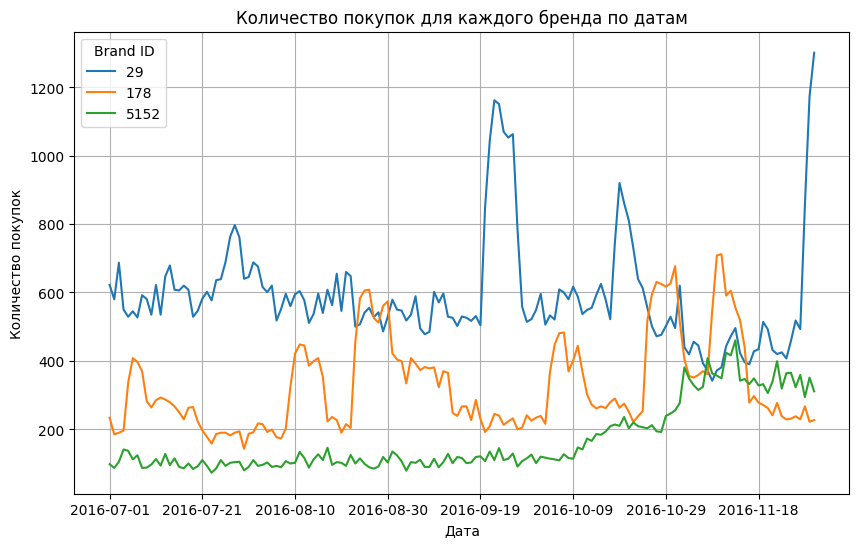

In [101]:
# Группируем данные по brand_id и дате
df_grouped = df.groupby(['date', 'brand_id'])['receipts_count'].sum().unstack()

df_grouped.plot(kind='line', figsize=(10, 6))

plt.title('Количество покупок для каждого бренда по датам')
plt.xlabel('Дата')
plt.ylabel('Количество покупок')
plt.legend(title='Brand ID')
plt.grid(True)

plt.show()

### Проведем анализ покупок чая "Ахмад"

In [103]:
df = df[df['brand_id'] == 178].copy().reset_index()
df = df[['date', 'receipts_count']].copy()
df = df.set_index(pd.DatetimeIndex(df['date']))

# Убедимся, что индекс имеет установленную частоту
df = df.asfreq('D')

df.drop(['date'], axis=1, inplace=True)

df

,receipts_count
date,
2016-07-01,234
2016-07-02,185
2016-07-03,190
2016-07-04,196
2016-07-05,336
...,...
2016-11-26,238
2016-11-27,229
2016-11-28,267


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 153 entries, 2016-07-01 to 2016-11-30
Freq: D
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   receipts_count  153 non-null    int64
dtypes: int64(1)
memory usage: 2.4 KB


None

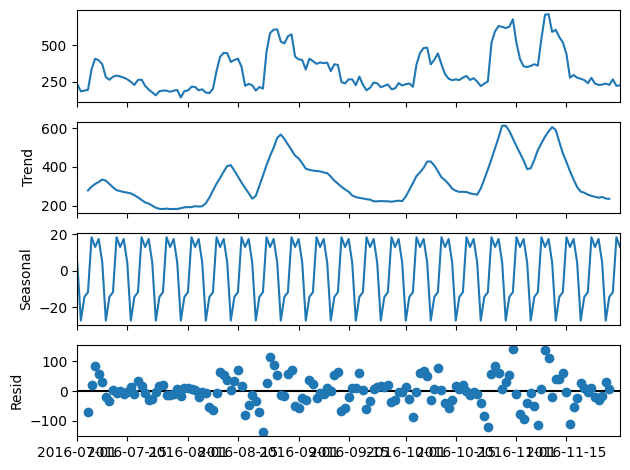

In [104]:
display(df.info())

# Выполним сезонную декомпозицию
decomposition = seasonal_decompose(df, model='additive')
decomposition.plot()
plt.show()

#### Выводы

* имеются явные колебания во времени в исходном ряде
* наблюдается четко выраженная сезонная компонента с регулярными колебаниями.
* шумовые данные с небольшими отклонениями от нуля, что указывает на стабильные остатки без значительных выбросов.
* трудно сказать, присутствует ли тренд, поэтому проверим ряд на стационарность

In [105]:
test = adfuller(df['receipts_count'])
print ('adf: ', test[0] )
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
if test[0] > test[4]['5%']: # проверка, больше ли критического полученное значение для нашего ряда
    print ('ряд не стационарен')
else:
    print ('ряд стационарен')

adf:  -2.1957361074439214
p-value:  0.2077966421397376
Critical values:  {'1%': -3.476597917537401, '5%': -2.8818291230495543, '10%': -2.5775887982253085}
ряд не стационарен


In [107]:
tau, p_value = kendalltau(df.index, df['receipts_count'])

print(f"Kendall's Tau: {tau}, p-value: {p_value}")

Kendall's Tau: 0.1900292941889008, p-value: 0.0005036111637733589


#### Выводы
* результаты ADF теста показывают, что временной ряд не является стационарным
* результаты теста Кендалла с высоким значением Tau и низким p-value указывают на наличие слабого, но значимого тренда в данных

### Предсказание продаж

Будем использовать модель `Prophet`, которая автоматически учитывает и тренд, и сезонность, и выбросы

In [119]:
from prophet import Prophet

# Сбрасываем индекс, чтобы даты стали отдельным столбцом
df_prepared = df.reset_index()

# Переименовываем столбцы в формат, ожидаемый Prophet
df_prepared = df_prepared.rename(columns={'date': 'ds', 'receipts_count': 'y'})

m = Prophet()
m.fit(df_prepared)
future = m.make_future_dataframe(periods=7)
forecast = m.predict(future)

py.iplot([
    go.Scatter(x=df_prepared['ds'], y=df_prepared['y'], name='y'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='yhat'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], fill='tonexty', mode='none', name='upper'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], fill='tonexty', mode='none', name='lower'),
    go.Scatter(x=forecast['ds'], y=forecast['trend'], name='Trend')
])

# Вычислим среднеквадратичную ошибку.
print('RMSE: %f' % np.sqrt(np.mean((forecast.loc[:df_prepared.shape[0] - 7, 'yhat']-df_prepared['y'])**2)) )

19:21:16 - cmdstanpy - INFO - Chain [1] start processing


19:21:16 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 125.863388


In [120]:
# Разные значения changepoint_prior_scale для эксперимента
changepoint_values = [0.01, 0.1, 0.5, 1.0, 2.0, 2.5]

# Словарь для хранения прогнозов
forecasts = {}

# Проходимся по разным значениям changepoint_prior_scale
for changepoint_prior_scale in changepoint_values:
    # Инициализируем модель с измененным changepoint_prior_scale
    m = Prophet(changepoint_prior_scale=changepoint_prior_scale)
    m.fit(df_prepared)

    # Строим прогноз
    future = m.make_future_dataframe(periods=7)
    forecast = m.predict(future)

    # Сохраняем прогноз
    forecasts[changepoint_prior_scale] = forecast

    # Визуализируем прогноз
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=df_prepared['ds'], y=df_prepared['y'], name='Actual'))
    fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], name=f'yhat (changepoint_prior_scale={changepoint_prior_scale})'))
    fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], fill='tonexty', mode='none', name='Upper Bound'))
    fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], fill='tonexty', mode='none', name='Lower Bound'))
    fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['trend'], name='Trend'))

    fig.update_layout(title=f'Prophet Forecast with changepoint_prior_scale={changepoint_prior_scale}',
                      xaxis_title='Date',
                      yaxis_title='Value',
                      showlegend=True)
    py.iplot(fig)

# Оценка RMSE для каждого из прогнозов
for changepoint_prior_scale, forecast in forecasts.items():
    rmse = np.sqrt(np.mean((forecast.loc[:df_prepared.shape[0] - 7, 'yhat'] - df_prepared['y']) ** 2))
    print(f'RMSE with changepoint_prior_scale={changepoint_prior_scale}: {rmse}')

19:22:18 - cmdstanpy - INFO - Chain [1] start processing
19:22:18 - cmdstanpy - INFO - Chain [1] done processing


19:22:18 - cmdstanpy - INFO - Chain [1] start processing
19:22:18 - cmdstanpy - INFO - Chain [1] done processing


19:22:19 - cmdstanpy - INFO - Chain [1] start processing
19:22:19 - cmdstanpy - INFO - Chain [1] done processing


19:22:19 - cmdstanpy - INFO - Chain [1] start processing
19:22:19 - cmdstanpy - INFO - Chain [1] done processing


19:22:19 - cmdstanpy - INFO - Chain [1] start processing
19:22:19 - cmdstanpy - INFO - Chain [1] done processing


19:22:19 - cmdstanpy - INFO - Chain [1] start processing
19:22:19 - cmdstanpy - INFO - Chain [1] done processing


RMSE with changepoint_prior_scale=0.01: 129.81549501055687
RMSE with changepoint_prior_scale=0.1: 125.89627408241199
RMSE with changepoint_prior_scale=0.5: 99.47697451067212
RMSE with changepoint_prior_scale=1.0: 92.13509713239762
RMSE with changepoint_prior_scale=2.0: 83.49727290430941
RMSE with changepoint_prior_scale=2.5: 80.61380472332517


#### Выводы

* Тренд недообучен при меньших значениях changepoint_prior_scale (0.01 и 0.1): Высокие значения RMSE указывают на то, что модель недостаточно гибка и не успевает за изменениями в данных. Модель не учитывает реальные изменения в тренде, что приводит к повышению ошибки.

* Снижение RMSE при увеличении changepoint_prior_scale: Как видно из данных, по мере увеличения changepoint_prior_scale ошибка RMSE уменьшается, что указывает на то, что модель становится более точной при учёте изменений в тренде.

* С учетом полученных данных, увеличение значения changepoint_prior_scale улучшает модель. Это говорит о том, что тренд в модели был недообучен при малых значениях коэффициента, и увеличение его до 2.5 улучшило результат.

In [123]:
# Добавим в модель месячную сезонность

changepoint_prior_scale = 2.5

m = Prophet(changepoint_prior_scale=changepoint_prior_scale)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m.fit(df_prepared)

# Строим прогноз
future = m.make_future_dataframe(periods=7)
forecast = m.predict(future)

# Визуализируем прогноз
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_prepared['ds'], y=df_prepared['y'], name='Actual'))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], name=f'yhat (changepoint_prior_scale={changepoint_prior_scale})'))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], fill='tonexty', mode='none', name='Upper Bound'))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], fill='tonexty', mode='none', name='Lower Bound'))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['trend'], name='Trend'))

fig.update_layout(title=f'Prophet Forecast with changepoint_prior_scale={changepoint_prior_scale}, period=30.5, fourier_order=5',
                    xaxis_title='Date',
                    yaxis_title='Value',
                    showlegend=True)
py.iplot(fig)

# Вычислим среднеквадратичную ошибку.
print('RMSE: %f' % np.sqrt(np.mean((forecast.loc[:df_prepared.shape[0] - 7, 'yhat']-df_prepared['y'])**2)) )

19:30:56 - cmdstanpy - INFO - Chain [1] start processing
19:30:56 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 62.744125


#### Выводы
* Модель улучшилась: cнижение RMSE с 80.61 до 62.74 после добавления месячной сезонности указывает на то, что модель стала лучше предсказывать временной ряд.

### Добавим информацию об играх "ЧГК"

Проверим, улучшится ли модель, если к ней добавить информацию об играх, где показывали рекламу чая.

In [125]:
import requests
from bs4 import BeautifulSoup

url = 'https://chgk.tvigra.ru/letopis/?2016'

# Получаем содержимое страницы
response = requests.get(url)
html_content = response.content

soup = BeautifulSoup(html_content, 'html.parser')

# Находим таблицу с классом 'txt'
table = soup.find('table', class_='txt')

# Извлекаем все даты из тегов <a> внутри таблицы
dates = [a.text for a in table.find_all('a')]

# Выводим даты
print(dates)


['27 марта', '3 апреля', '10 апреля', '17 апреля', '24 апреля', '15 мая', '22 мая', '29 мая', '5 июня', '19 июня', '25 сентября', '2 октября', '9 октября', '16 октября', '23 октября', '20 ноября', '27 ноября', '11 декабря', '18 декабря', '25 декабря']


In [126]:
# Преобразуем список с датами в формат YYYY-MM-DD

months = {
    'января': '01', 'февраля': '02', 'марта': '03', 'апреля': '04', 'мая': '05',
    'июня': '06', 'июля': '07', 'августа': '08', 'сентября': '09', 'октября': '10',
    'ноября': '11', 'декабря': '12'
}

# Преобразуем даты в формат YYYY-MM-DD
formatted_dates = []
for date in dates:
    day, month_rus = date.split()
    month_num = months[month_rus]
    formatted_date = f"2016-{month_num}-{int(day):02d}"
    formatted_dates.append(formatted_date)

# Выводим список с датами в формате YYYY-MM-DD
print(formatted_dates)

['2016-03-27', '2016-04-03', '2016-04-10', '2016-04-17', '2016-04-24', '2016-05-15', '2016-05-22', '2016-05-29', '2016-06-05', '2016-06-19', '2016-09-25', '2016-10-02', '2016-10-09', '2016-10-16', '2016-10-23', '2016-11-20', '2016-11-27', '2016-12-11', '2016-12-18', '2016-12-25']


#### Добавление дней показа рекламы как праздники

In [139]:
# Создаем датафрейм для "праздников" (дней показа рекламы)
ads_dates = pd.DataFrame({
    'holiday': 'ads_day',  # Название события
    'ds': pd.to_datetime(formatted_dates),  # Список дат показа рекламы
    'lower_window': 0,  # Число дней до события, влияющих на модель
    'upper_window': 1   # Число дней после события, которые могут влиять на данные

})

changepoint_prior_scale = 2.5

m = Prophet(changepoint_prior_scale=changepoint_prior_scale, holidays=ads_dates)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m.fit(df_prepared)

# Строим прогноз
future = m.make_future_dataframe(periods=7)
forecast = m.predict(future)

# Визуализируем прогноз
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_prepared['ds'], y=df_prepared['y'], name='Actual'))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], name=f'yhat (changepoint_prior_scale={changepoint_prior_scale})'))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], fill='tonexty', mode='none', name='Upper Bound'))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], fill='tonexty', mode='none', name='Lower Bound'))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['trend'], name='Trend'))

fig.update_layout(title=f'Prophet Forecast with changepoint_prior_scale={changepoint_prior_scale}, period=30.5, fourier_order=5',
                    xaxis_title='Date',
                    yaxis_title='Value',
                    showlegend=True)
py.iplot(fig)

# Вычислим среднеквадратичную ошибку.
print('RMSE: %f' % np.sqrt(np.mean((forecast.loc[:df_prepared.shape[0] - 7, 'yhat']-df_prepared['y'])**2)) )

19:51:41 - cmdstanpy - INFO - Chain [1] start processing
19:51:41 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 62.667563


#### Добавление дней показа рекламы как регрессоры

Добавим бинарный регрессор, который будет принимать значение 1 для дней показа рекламы и 0 для остальных дней. Это позволяет модели учитывать влияние рекламы на прогнозы.

In [128]:
df_prepared_reg = df_prepared.copy()

# Добавляем бинарный столбец, где 1 — это день показа рекламы, 0 — остальные дни
df_prepared_reg['ads_day'] = df_prepared_reg['ds'].isin(formatted_dates).astype(int)

changepoint_prior_scale = 2.5

m = Prophet(changepoint_prior_scale=changepoint_prior_scale)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m.add_regressor('ads_day')
m.fit(df_prepared_reg)

# Строим прогноз
future = m.make_future_dataframe(periods=7)
future['ads_day'] = future['ds'].isin(formatted_dates).astype(int)
forecast = m.predict(future)

# Визуализируем прогноз
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_prepared_reg['ds'], y=df_prepared_reg['y'], name='Actual'))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], name=f'yhat (changepoint_prior_scale={changepoint_prior_scale})'))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], fill='tonexty', mode='none', name='Upper Bound'))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], fill='tonexty', mode='none', name='Lower Bound'))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['trend'], name='Trend'))

fig.update_layout(title=f'Prophet Forecast with changepoint_prior_scale={changepoint_prior_scale}, period=30.5, fourier_order=5',
                    xaxis_title='Date',
                    yaxis_title='Value',
                    showlegend=True)
py.iplot(fig)

# Вычислим среднеквадратичную ошибку.
print('RMSE: %f' % np.sqrt(np.mean((forecast.loc[:df_prepared_reg.shape[0] - 7, 'yhat']-df_prepared_reg['y'])**2)) )

19:42:32 - cmdstanpy - INFO - Chain [1] start processing
19:42:32 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 63.191518


#### Выводы
* попробовали два способа добавить информацию о рекламе: как праздники и как регрессоры
* при обоих способах RMSE увеличилась с 62.74 до 63.19
* при изменинии парамтра `upper_window = 1` RMSE уменьшилась до 62.66, что говорим о том, что влияние рекламы проявилось с задержкой в 1 день (при увеличении окна до 2 и выше - метрика оценки модели ухудшается)

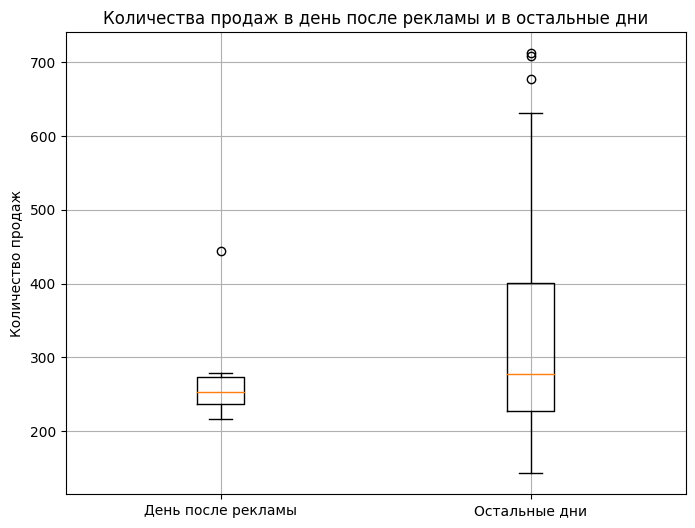

In [154]:
data = df_prepared.copy()

formatted_dates_ts = pd.to_datetime(formatted_dates)

# Создаем бинарный столбец, где 1 — это день после рекламы, 0 — остальные дни
data['is_ads_period'] = data['ds'].isin(formatted_dates_ts + pd.Timedelta(days=1))

# Подготовка данных для боксплота
data['period'] = data['is_ads_period'].map({True: 'День после рекламы', False: 'Остальные дни'})

# Создаем два набора данных
ads_data = data[data['is_ads_period'] == True]['y']  # День после рекламы
non_ads_data = data[data['is_ads_period'] == False]['y']  # Остальные дни

# Строим boxplot
plt.figure(figsize=(8, 6))
plt.boxplot([ads_data, non_ads_data], labels=['День после рекламы', 'Остальные дни'])
plt.title('Количества продаж в день после рекламы и в остальные дни')
plt.ylabel('Количество продаж')
plt.grid(True)
plt.show()


### Выводы
* Медиана продаж выше в обычные дни, чем в дни после рекламы. Это может указывать на то, что реклама не оказывает значительного влияния на резкий рост продаж.

* Продажи в день после рекламы более стабильны, с меньшими колебаниями, что может означать, что реклама не создает резких изменений в поведении покупателей.

* Аномалий роста продаж после рекламы не наблюдается, так как ни медиана, ни разброс продаж не показывают значительных изменений по сравнению с остальными днями.

### Попробуем кластеризовать точки продаж

Применим `AgglomerativeClustering` для поиска аномалий

In [156]:
df = pd.read_csv('tea_demand.zip', sep='\t')
display(df)

,brand_id,date,receipts_count
0,5152,2016-07-01,98
1,178,2016-07-01,234
2,29,2016-07-01,622
3,5152,2016-07-02,87
4,178,2016-07-02,185
...,...,...,...
454,178,2016-11-29,222
455,29,2016-11-29,1173
456,5152,2016-11-30,311
457,178,2016-11-30,227


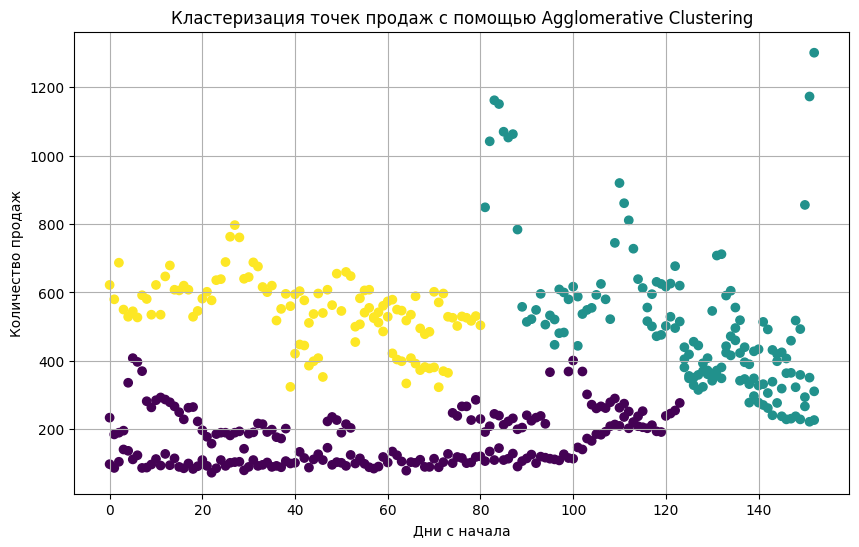

=== Аномалии ===


,brand_id,date,receipts_count,days_since_start,cluster


In [170]:
df['date'] = pd.to_datetime(df['date'])

# преобразование даты в числовой формат (количество дней с минимальной даты)
df['days_since_start'] = (df['date'] - df['date'].min()).dt.days

# нормализация данных (используем только 'receipts_count' и 'days_since_start')
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[['receipts_count', 'days_since_start']])

# применение Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=3)  # мы знаем, сколько кластеров должно быть
df['cluster'] = agg_clustering.fit_predict(df_scaled)

# визуализация результатов кластеризации
plt.figure(figsize=(10, 6))
plt.scatter(df['days_since_start'], df['receipts_count'], c=df['cluster'], cmap='viridis')
plt.xlabel('Дни с начала')
plt.ylabel('Количество продаж')
plt.title('Кластеризация точек продаж с помощью Agglomerative Clustering')
plt.grid(True)
plt.show()

# поиск аномалий (небольшие кластеры или кластеры с необычным поведением можно считать аномалиями)
# Считаем количество точек в каждом кластере
cluster_counts = df['cluster'].value_counts()

# определяем аномалии как точки, принадлежащие кластерам с малым количеством точек
# например, кластеры с менее чем 5 точками можно считать аномальными
anomaly_clusters = cluster_counts[cluster_counts < 5].index
anomalies = df[df['cluster'].isin(anomaly_clusters)]

# Выводим найденные аномалии
print('=== Аномалии ===')
anomalies

### Вывод

* Эфект рекламы не вызывает резкого роста продаж чая "Ахмад" на следующий день, и в целом продажи остаются более стабильными после показа рекламы.

* Любители передачи "Что?Где?Когда?", возможно, не являются целевой аудиторией потребителей чая "Ахмад"